#  Autoencoder for image denoising
 

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [2]:

# Some functions to process and display data

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

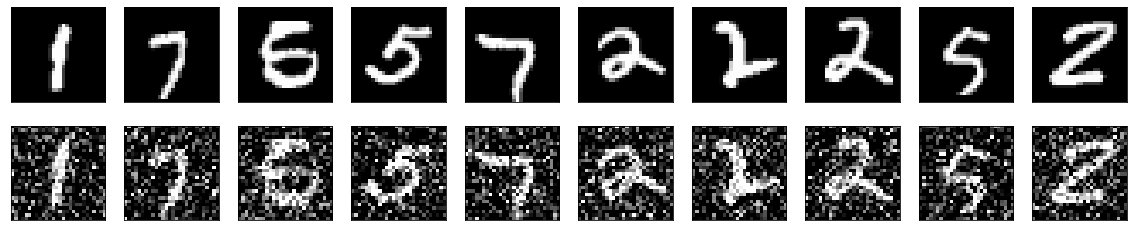

In [3]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.
Read this for more informatin about functional model

https://machinelearningmastery.com/keras-functional-api-deep-learning/

In [4]:
input = layers.Input(shape=(28, 28, 1))    #functional model

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248  

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 37s 17ms/step - loss: 0.1353 - val_loss: 0.0723
Epoch 2/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0710 - val_loss: 0.0691
Epoch 3/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0690 - val_loss: 0.0679
Epoch 4/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0679 - val_loss: 0.0669
Epoch 5/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0671 - val_loss: 0.0664
Epoch 6/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0665 - val_loss: 0.0658
Epoch 7/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0661 - val_loss: 0.0655
Epoch 8/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0658 - val_loss: 0.0651
Epoch 9/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0654 - val_loss: 0.0648
Epoch 10/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0651 - val_l

Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

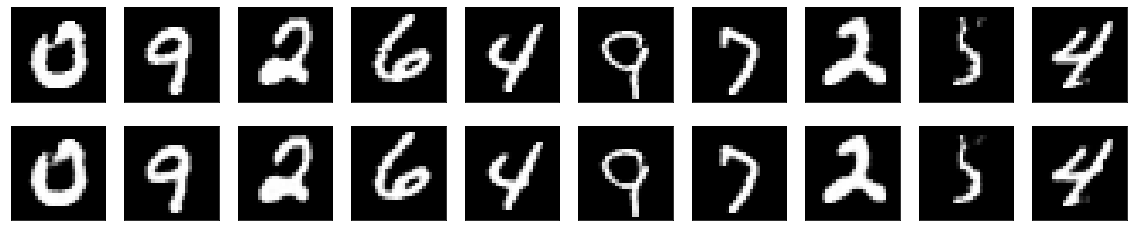

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [6]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 7s 16ms/step - loss: 0.1014 - val_loss: 0.0941
Epoch 2/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0936 - val_loss: 0.0919
Epoch 3/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0920 - val_loss: 0.0907
Epoch 4/100
469/469 [==============================] - 7s 16ms/step - loss: 0.0909 - val_loss: 0.0900
Epoch 5/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0902 - val_loss: 0.0893
Epoch 6/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0897 - val_loss: 0.0889
Epoch 7/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0892 - val_loss: 0.0884
Epoch 8/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0888 - val_loss: 0.0881
Epoch 9/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0885 - val_loss: 0.0879
Epoch 10/100
469/469 [==============================] - 7s 15ms/step - loss: 0.088

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

In [1]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

NameError: ignored